# <font color = blue>Банки — Сегментация пользователей по потреблению</font>

Исследование для банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск

### Задача**:**

Проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов.

- Провести исследовательский анализ данных,
- Сегментировать пользователей на основе данных о количестве потребляемых продуктов,
- Сформулировать и проверьте статистические гипотезы.

### **Описание данных:**

Колонки датасета с данными о клиентах:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## 1. Загрузка и предобработка данных

In [101]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

In [102]:
# Загрузим данные
clients = pd.read_csv('bank_dataset.csv')

In [103]:
# Просмотрим первые 10 строк
clients.head(10)

userid  score            City Gender  Age  Objects   Balance  Products  \
0  15677338    619       Ярославль      Ж   42        2       nan         1   
1  15690047    608         Рыбинск      Ж   41        1  83807.86         1   
2  15662040    502       Ярославль      Ж   42        8 159660.80         3   
3  15744090    699       Ярославль      Ж   39        1       nan         2   
4  15780624    850         Рыбинск      Ж   43        2 125510.82         1   
5  15616748    645         Рыбинск      М   44        8 113755.78         2   
6  15635267    822       Ярославль      М   50        7       nan         2   
7  15698884    376  Ростов Великий      Ж   29        4 115046.74         4   
8  15835101    501       Ярославль      М   44        4 142051.07         2   
9  15635125    684       Ярославль      М   27        2 134603.88         1   

   CreditCard  Loyalty  estimated_salary  Churn  
0           1        1         101348.88      1  
1           0        1         112542.58      0  
2           1        0         113931.57      1  
3           0        0          93826.63      0  
4           1        1          79084.10      0  
5           1        0         149756.71      1  
6           1        1          10062.80      0  
7           1        0         119346.88      1  
8           0        1          74940.50      0  
9           1        1          71725.73      0

In [104]:
# Просмотрим общую информацию
clients.info(10)
clients.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


userid    score      Age  Objects   Balance  Products  CreditCard  \
count    10000.00 10000.00 10000.00 10000.00   6383.00  10000.00    10000.00   
mean  15733676.57   650.53    38.92     5.01 119827.49      1.53        0.71   
std      71936.19    96.65    10.49     2.89  30095.06      0.58        0.46   
min   15608437.00   350.00    18.00     0.00   3768.69      1.00        0.00   
25%   15671264.25   584.00    32.00     3.00 100181.98      1.00        0.00   
50%   15733474.00   652.00    37.00     5.00 119839.69      1.00        1.00   
75%   15795969.75   718.00    44.00     7.00 139512.29      2.00        1.00   
max   15858426.00   850.00    92.00    10.00 250898.09      4.00        1.00   

       Loyalty  estimated_salary    Churn  
count 10000.00          10000.00 10000.00  
mean      0.52         100090.24     0.20  
std       0.50          57510.49     0.40  
min       0.00             11.58     0.00  
25%       0.00          51002.11     0.00  
50%       1.00         100193.91     0.00  
75%       1.00         149388.25     0.00  
max       1.00         199992.48     1.00

**Типы данных корректные**.
Видим, что есть **пропуски** в столбце с данными о балансе на счете. Возможно, есть записи с одинаковым User_id, часть из которых содержит информацию о балансе, а другая - нет, тогда сможем восстановить необходимую информацию. Поверим это.

In [105]:
clients['userid'].nunique()

10000

Видим, что каждый id встречается 1 раз, восстановить информацию по имеющимся данным невозможно. Заполнение средним и медианой считаю нецелесообразным, т.к. данный параметр достаточно индивидуален. Пользователи с одним уровнем дохода могут иметь различное поведение - один оставляет средства на балансе, другой снимает.  

**Промаркируем пропуски** и проведем анализ по имеющимся данным.

In [106]:
clients['Balance'] = clients['Balance'].fillna(-100000)

Приведем названия столбцов к **нижнему регистру**. **Переименуем** столбцы userid и creditcard для улучшения читабельности.

In [107]:
clients.columns=clients.columns.str.lower().str.replace(' ', '_')

In [108]:
clients.rename(columns = {'userid': 'user_id', 'creditcard': 'credit_card'}, inplace = True)

Проверим наличие полных **дубликатов**.

In [109]:
display(clients.duplicated().value_counts())

False    10000
dtype: int64

Дубликатов нет. Данные подготовлены к дальнейшему анализу.

Просмотрим распределения признаков, чтобы выявить характер распределений.

In [110]:
for col in clients.columns:
    fig = px.histogram(clients[col], x = col, width = 600, height = 400, title = col + ' histogram')
    fig.show()

Большинство непрерывных распределений близки к равномерным, однако из-за наличия в ряду признаков дискретных величин, группы пользователей по которым распределены неравномерно, для общей оценки среднего буду использовать медиану.

## 2. Исследовательский анализ данных

### 2.1 Составим портрет типичного клиента (изучим средние значения показателей):

    * для всех клиентов банка в целом,
    * в срезе городов.

Просмотрим средние значения показателей (в качестве меры среднего использую медиану).

In [111]:
clients.median()

user_id            15733474.00
score                   652.00
age                      37.00
objects                   5.00
balance               97198.54
products                  1.00
credit_card               1.00
loyalty                   1.00
estimated_salary     100193.91
churn                     0.00
dtype: float64

Типичный клиент банка имеет кредитный скоринг порядка 650, возраст 37 лет, 5 объектов в собственности, баланс 97 тыс, оценочную заработную плату 100 тыс, пользуется кредитной картой, является активным.

Сгруппируем клиентов по городам и рассмотрим отличия портрета клиентов из разных городов.

In [112]:
clients.groupby('city').agg('median').reset_index().drop(
    'user_id', axis = 1).merge(clients.groupby('city').agg({'user_id':'count'}).reset_index(), on = 'city')

city  score  age  objects   balance  products  credit_card  \
0  Ростов Великий    651   38        5 119703.10         1            1   
1         Рыбинск    651   37        5  61710.44         2            1   
2       Ярославль    653   37        5  62153.50         1            1   

   loyalty  estimated_salary  churn  user_id  
0        0         102397.22      0     2509  
1        1          99984.86      0     2477  
2        1          99132.31      0     5014

Можно отметить, что число клиентов в Ярославле превышает число клиентов в каждом из двух других городов в 2 раза. 

Видим, что клиенты в Ростове Великом имеют наибольшее значение баланса на счете и заработной платы, но при этом меньшую активность. В Рыбинске клиент использует в среднем большее количество продуктов банка.

### 2.2  Исследуем баллы кредитного скоринга клиентов:

Просмотрим распределение баллов скоринга

In [113]:
fig = px.histogram(clients['score'], x = 'score', nbins = 50, width = 600, height = 400, title = 'Clients credit score')
fig.show()

Видим, что скоринг распределен достаточно равномерно, за исключением высокого пика вблизи максимального значения (840 - 859). Определим долю клиентов с хорошим скорингом.

In [114]:
# Доля клиентов с уровнем скоринга "приемлемый" и выше 
len(clients.query('score > 600'))/len(clients)

0.6934

In [115]:
# Доля надежных клиентов - скоринг 690-850
len(clients.query('score > 690'))/len(clients)

0.3472

69% клиентов имеют баллы скоринга более 600, который соответствует уровню "приемлемый". При этом 35% процентов относятся к категории с максимальным результатом (690 - 850) и являются надежными заемщиками. На основании этого можно рекомендовать банку активно предлагать различные кредитные продукты клиентам.

### 2.3 Исследуем финансовую состоятельность клиентов:
- показатели количество объектов в собственности, баланс на счете и заработная плата клиента,
- посмотреть соотношение баланса на счете и заработной платы - так можем предположить, доверяет ли клиент банку основную часть финансов
- проанализировать, есть ли различия в поведении клиентов с разным уровнем доходов/состояния - по числу продуктов, активности, кредиткам, оттоку

Рассмотрим распределения количества объектов собственности, баланса на счете и заработной платы

In [116]:
fig = px.histogram(clients['objects'], x = 'objects', nbins = 21, 
                   width = 600, height = 400, title = 'Clients objects')
fig.show()


Видим, что число клиентов с количеством объектов от 1 до 9 примерно одинаково. Меньше клиентов имеют 0 и 10 объектов.

Рассмотрим распределения средств на счете и заработной платы

In [117]:
fig = px.histogram(clients.query('balance > 0')['balance'], x = 'balance', nbins = 60, 
                   width = 600, height = 400, title = 'Clients balance')
fig.show()

In [118]:
fig = px.histogram(clients['estimated_salary'], x = 'estimated_salary', nbins = 100, width = 600, height = 400, 
                   title = 'Clients Salary')
fig.show()


Для сопоставления баланса и заработной платы, построим также распределение для клиентов, у которых известен баланс.

In [119]:
fig = px.histogram(clients.query('balance > 0')['estimated_salary'], x = 'estimated_salary', nbins = 100, 
                   width = 600, height = 400, 
                   title = 'Salary of clients with a known balance')
fig.show()

**!!** Видим, что распределения баланса и заработной платы существенно различаются. Это позволяет сделать вывод о том, что далеко не все клиенты содержат большую часть своих доходов на счете. Можно рекомендовать банку проработать и предложить, например, более привлекательные условия капитализации, кэшбэка.

Проанализируем, есть ли различия в поведении клиентов с разным уровнем доходов/состояния - по числу продуктов, активности, кредиткам, оттоку 


In [120]:
# Разобьем клиентов на несколько категорий по уровню дохода 

# Определяем квантили для разбиения клиентов по уровню дохода
salary_levels = clients['estimated_salary'].quantile([.33, .66])
display(salary_levels)
# Функция для разбиения дохода на некоторые группы
def salary_category(salary):
    if salary <= salary_levels[0.33]:
        return 'low'
    if salary_levels[0.33] < salary <= salary_levels[0.66]:
        return 'average'
    if salary > salary_levels[0.66]:
        return 'high'
    
clients['income_category'] = clients['estimated_salary'].apply(salary_category)
display(clients.head(10))

0.33    66392.42
0.66   131508.52
Name: estimated_salary, dtype: float64

user_id  score            city gender  age  objects    balance  products  \
0  15677338    619       Ярославль      Ж   42        2 -100000.00         1   
1  15690047    608         Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502       Ярославль      Ж   42        8  159660.80         3   
3  15744090    699       Ярославль      Ж   39        1 -100000.00         2   
4  15780624    850         Рыбинск      Ж   43        2  125510.82         1   
5  15616748    645         Рыбинск      М   44        8  113755.78         2   
6  15635267    822       Ярославль      М   50        7 -100000.00         2   
7  15698884    376  Ростов Великий      Ж   29        4  115046.74         4   
8  15835101    501       Ярославль      М   44        4  142051.07         2   
9  15635125    684       Ярославль      М   27        2  134603.88         1   

   credit_card  loyalty  estimated_salary  churn income_category  
0            1        1         101348.88      1         average  
1            0        1         112542.58      0         average  
2            1        0         113931.57      1         average  
3            0        0          93826.63      0         average  
4            1        1          79084.10      0         average  
5            1        0         149756.71      1            high  
6            1        1          10062.80      0             low  
7            1        0         119346.88      1         average  
8            0        1          74940.50      0         average  
9            1        1          71725.73      0         average

Резделили клиентов на классы по категории, при этом квантиль 0.33 соответствует зарплате 66 тыс, что близко к нижнему пороговому значению доходов среднего класса в регионах РФ.

Проанализируем поведение клиентов с различным уровнем дохода по следующим показателям: по числу продуктов, активности, кредиткам, оттоку.

In [121]:
columns_list = ['products', 'credit_card', 'loyalty', 'churn']

for col in columns_list: # дискретные величины
    fig = px.histogram( clients, x='income_category', y= col, title = col,width = 500, height = 350)   
    fig.show()

Видим, что нет существенных различий по числу продуктов, активности, кредиткам, оттоку среди клиентов с разным уровнем дохода. 

### 2.4 Сегментируем клиентов по количеству потребляемых продуктов:
- посмотреть распределение
- составить портрет пользователей с разным количеством продуктов

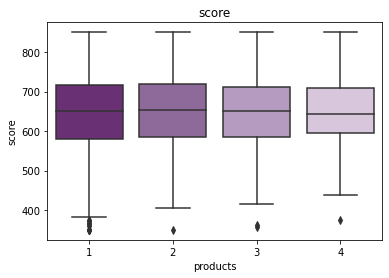

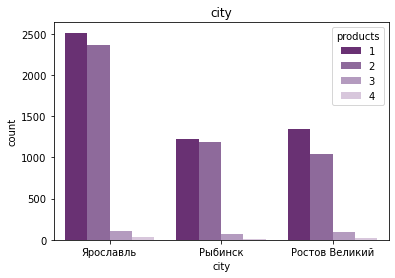

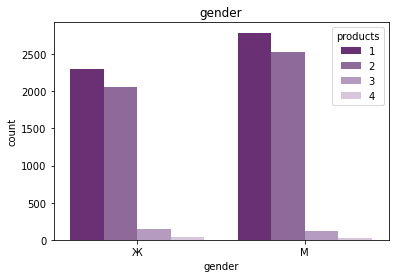

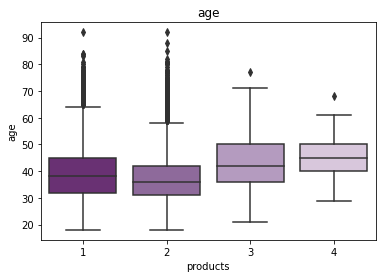

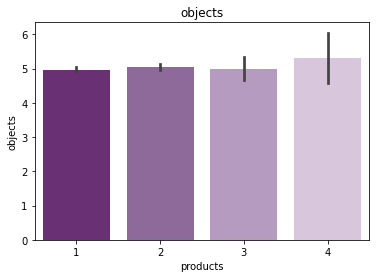

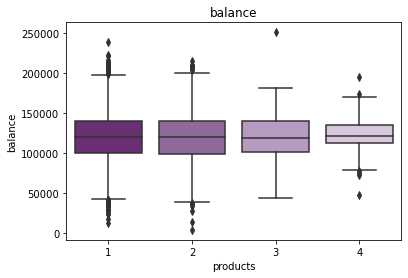

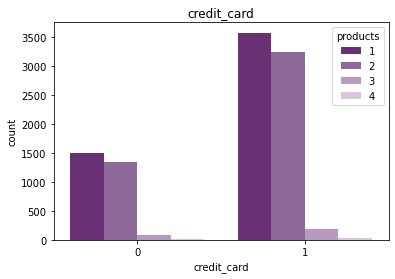

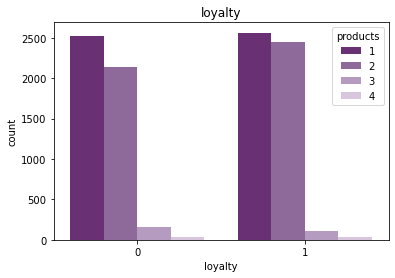

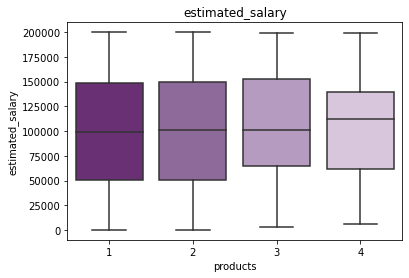

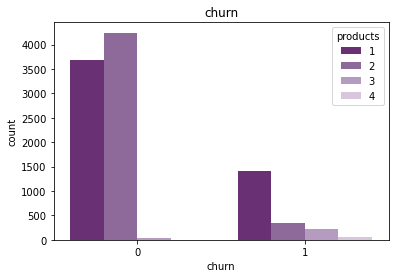

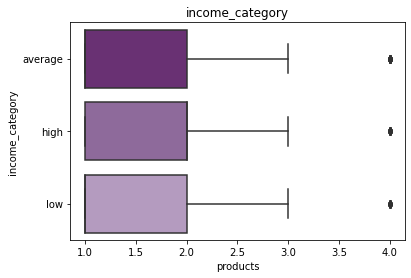

In [122]:
# Сгруппируем пользователей по количеству потребляемых продуктов и просмотрим распределения признаков

discrets = ['objects'] # дискретные признаки
categories = [ 'income_category'] # категориальные признаки
binary = ['churn', 'loyalty', 'credit_card', 'city', 'gender'] # бинарные признаки. Остальные - непрерывные или близкие к ним

plt.figure()
for col in clients.columns:
    if (col !='products') & (col !='user_id'):
        if col == 'balance':
            df = clients.query('balance >0')
        else:
            df = clients
        plt.title(col)
    
        if col in binary: #бинарные данные
            sns.countplot(x = col, hue = 'products', data = df)
    
        elif col in discrets: # дискретные величины
            sns.barplot(x='products', y= col, data=df)
    
        else: # непрерывные или близкие к ним величины
            sns.boxplot(x='products', y= col, data= df)
        plt.show()

Выведем также средние численные значение, сгруппировав клиентов по количеству используемых продуктов

In [123]:
clients_products = clients.groupby('products').agg('median').reset_index().drop(
    'user_id', axis = 1).merge(clients.groupby('products').agg({'user_id':'count'}).reset_index(), on = 'products')
clients_products['users_part'] = clients_products['user_id']/clients_products['user_id'].sum()
clients_products

products  score   age  objects    balance  credit_card  loyalty  \
0         1 651.00 38.00     5.00  111886.04         1.00     1.00   
1         2 653.00 36.00     5.00 -100000.00         1.00     1.00   
2         3 650.00 42.00     5.00   95973.93         1.00     0.00   
3         4 643.00 45.00     5.00  116808.20         1.00     0.00   

   estimated_salary  churn  user_id  users_part  
0          99226.83   0.00     5084        0.51  
1         100738.85   0.00     4590        0.46  
2         101046.89   1.00      266        0.03  
3         112163.11   1.00       60        0.01

Сегментировав клиентов по числу используемых продуктов, определили следующее: 

Доля клиентов с 1 и 2 продуктами примерно одинакова - 51% и 46%.

Скоринг существенно не различается, как нет существенных различий по городам, полу, числу объектов в собственности, балансу, кредитным картам, заработной плате. 

Возраст клиентов, использующих 3 и 4 продукта выше, чем остальных. Моложе всех - пользователи 2 продуктов. 
Доля активных пользователей среди клиентов с 2 продуктами выше, чем в других группах. 
 
Практически все клиенты с 3 и 4 продуктами ушли в отток, а среди пользователей 1 и 2 продуктов большинство остались

### 2.5 Проанализируем использование кредитных карт:
- сколько клиентов используют кредитные карты;
- различаются ли возраст, пол, город, доход пользователей с кредитными картами и без них

Доля клиентов, использующих кредитные карты

In [124]:
credit_card_part = len(clients.query('credit_card == 1'))/len(clients)
credit_card_part

0.7055

Видим, что 70,5% клиентов пользуются кредитными картами.

Изучим, различаются ли возраст, пол, город, доход пользователей с кредитными картами и без них

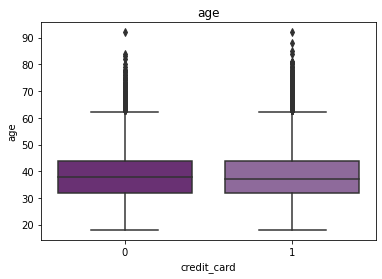

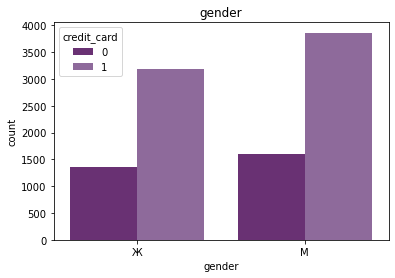

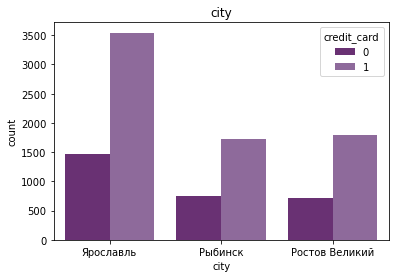

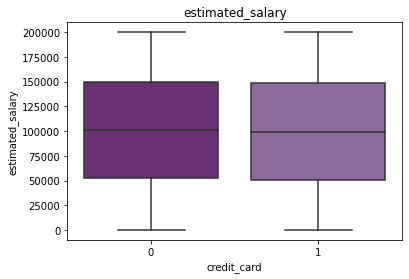

In [125]:

plt.figure()
for col in ['age', 'gender', 'city', 'estimated_salary']:
    if (col !='products') & (col !='user_id'):
        df = clients
        plt.title(col)
    
        if col in binary: #бинарные данные
            sns.countplot(x = col, hue = 'credit_card', data = df)
    
        elif col in discrets: # дискретные величины
            sns.barplot(x='credit_card', y= col, data=df)
    
        else: # непрерывные или близкие к ним величины
            sns.boxplot(x='credit_card', y= col, data= df)
        plt.show()

Видим, что возраст клиентов с кредитными картами и без них существенно не различается. Доля клиентов с кредитками среди мужчин больше, чем среди женщин. Доля держателей кредитных карт существенно не различается по городам и также не зависит от заработной платы.

### 2.6 Исследуем клиентов, ушедших в отток:
- выявим особенности ушедших клиентов

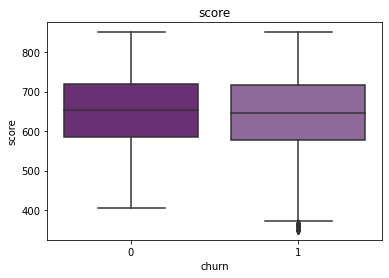

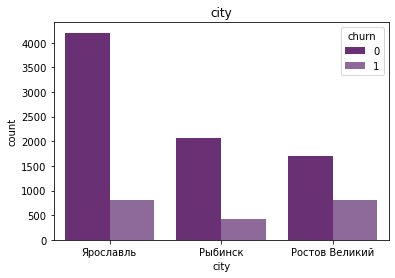

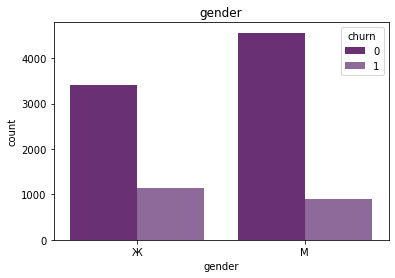

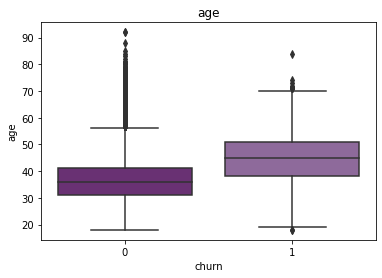

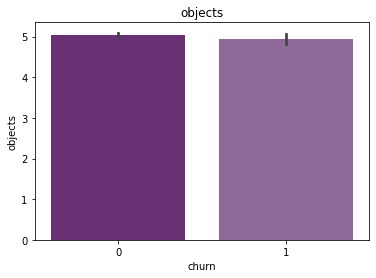

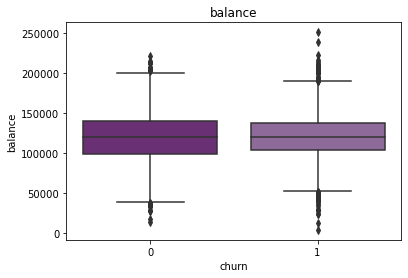

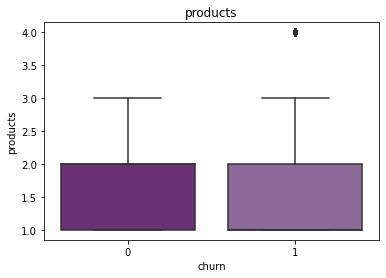

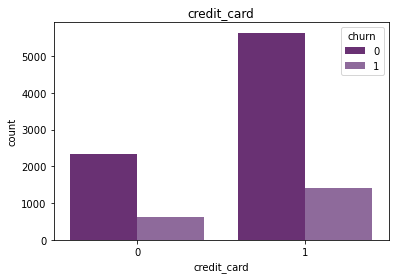

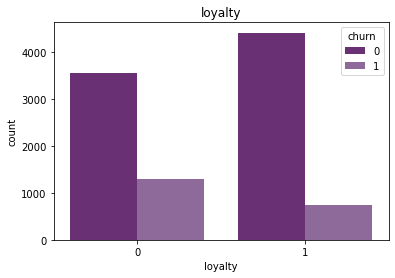

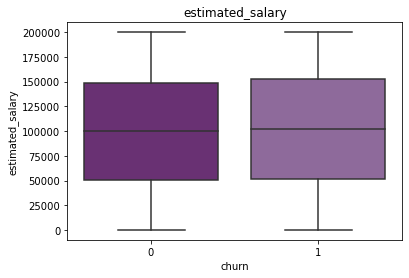

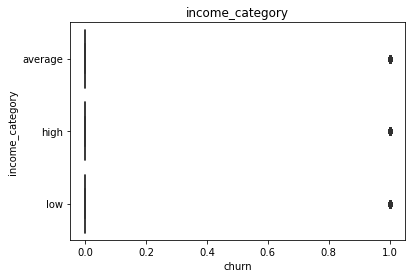

In [126]:
# Построим диаграммы характеристик клиентов, сгруппировав их по признаку оттока
plt.figure()
for col in clients.columns:
    if (col !='churn') & (col !='user_id'):
        if col == 'balance':
            df = clients.query('balance >0')
        else:
            df = clients
        plt.title(col)
    
        if col in binary: #бинарные данные
            sns.countplot(x = col, hue = 'churn', data = df)
    
        elif col in discrets: # дискретные величины
            sns.barplot(x='churn', y= col, data=df)
    
        else: # непрерывные или близкие к ним величины
            sns.boxplot(x='churn', y= col, data= df)
        plt.show()

Видим, что скоринг, число объектов в собственности, баланс, заработная плата, число продуктов, доля использования кредитных карт действующих клиентов и клиентов оттока существенно не различется. 

наибольшая доля клиентов оттока  - в Ростове Великом, следует проанализировать, какие факторы могли повлиять - качество обслуживания, предложения конкурентов и т.д. 

Среди клиентов оттока больше женщин.
Средний возраст клиентов оттока выше - возможно, следует уделить больше внимания традиционному обсуживанию взамен все больше внедряемым веб и мобильным средствам.

Среди активных клиенов меньше доля оттока.

## 3 Статистический анализ

Проверим гипотезы:

**3.1 различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним**; 

`Нулевая гипотеза H0`: 
средние доходы клиентов-пользователей 1 продукта и клиентов-пользователей 2 продуктов **равны**;

`Альтернативная гипотеза H1`: 
средние доходы клиентов-пользователей 1 продукта и клиентов-пользователей 2 продуктов **различны**.

Для проверки гипотезы о равенстве средних используем t-тест (метод scipy.stats.ttest_ind).

In [127]:
alpha = 0.05 # задаем уровень значимости

def stat_proverka(df, column_learned, column_parameter, value_1, value_2):
    """
    Функция для проверки равенства средних выборок
    
    """
    sample_1 = df[df[column_parameter] == value_1][column_learned]
    sample_2 = df[df[column_parameter] == value_2][column_learned]
    results = st.ttest_ind(sample_1,sample_2, equal_var = False)#тк выборки обладают разной дисперсией
    display(results.pvalue)
    
    if results.pvalue < alpha:
        display('Отвергаем гипотезу о равенстве')
    else:
        display('Не удалось отвергнуть гипотезу о равенстве')



Таким образом, не можем утверждать, что доходы клиентов, использующих 1 продукт, и клиентов, пользующизся 2 продуктами банка, различны.

**3.2 Различия дохода между клиентами с кредитными картами и без них**

`Нулевая гипотеза H0`: 
средние доходы клиентов с кредитными картами и клиентов без кредитных карт **равны**;

`Альтернативная гипотеза`: 
средние доходы клиентов с кредитными картами и клиентов без кредитных карт **различны**.

In [128]:
# Проверим гипотезу о равенстве средних доходов
display('Сравним доходы клиентов-пользователей 1 и 2 продуктов')
stat_proverka(clients, 'estimated_salary','credit_card', 0, 1)

'Сравним доходы клиентов-пользователей 1 и 2 продуктов'

0.3218408485577436

'Не удалось отвергнуть гипотезу о равенстве'

По результатам проверки гипотезы не можем утверждать, что доходы клиентов, использующих кредитные карты, и клиентов без кредитных карт различны.

##  Выводы

В результате исследований предоставленных данных о клиентах банка «Метанпром» установлено:

* **Портрет типичного клиента** банка: 

    кредитный скоринг порядка 650, возраст 37 лет, 5 объектов в собственности, баланс 97 тыс, оценочную заработную плату 100 тыс, пользуется кредитной картой, является активным. 
    
    
* Различия клиентов **по городам**:

   - число клиентов в Ярославле превышает число клиентов в каждом из двух других городов в 2 раза;
   - клиенты в Ростове Великом имеют наибольшее значение баланса на счете и заработной платы, но при этом меньшую активность;
   - в Рыбинске клиент использует в среднем большее количество продуктов банка. 
   

* Анализ **кредитного скоринга** клиентов:

    - 69% клиентов имеют баллы скоринга более 600, который соответствует уровню "приемлемый";
    - 35% процентов относятся к категории с максимальным результатом (690 - 850) и являются надежными заемщиками. 
    
    На основании этого можно рекомендовать банку активно предлагать различные кредитные продукты клиентам. 
    

* Анализ **уровня дохода**

    - распределения баланса и заработной платы существенно различаются. Это позволяет сделать вывод о том, что далеко не все клиенты содержат большую часть своих доходов на счете. Можно рекомендовать банку проработать и предложить, например, более привлекательные условия капитализации, кэшбэка.

    - не выявлено существенных различий по числу продуктов, активности, кредиткам, оттоку среди клиентов с разным уровнем дохода.


* Сегментация клиентов **по числу используемых продуктов**: 

    - доля клиентов с 1 и 2 продуктами примерно одинакова - 51% и 46%;
    - возраст клиентов, использующих 3 и 4 продукта выше, чем остальных. Моложе всех - пользователи 2 продуктов;
    - доля активных пользователей среди клиентов с 2 продуктами выше, чем в других группах; 
    - в группе с 1 и 2 продуктами число оставшихся клиентов превышает отток в отличие от групп с 3 и 4 продуктами.


* Анализ клиентов с **кредитными картами** 

    - 70,5% клиентов пользуются кредитными картами;
    - возраст клиентов с кредитными картами и без них существенно не различается;
    - доля клиентов с кредитками среди мужчин больше, чем среди женщин;
    - доля держателей кредитных карт существенно не различается по городам и также не зависит от заработной платы.

* Анализ клиентов **оттока**

    - наибольшая доля клиентов оттока - в Ростове Великом, 
    - среди клиентов оттока больше женщин;
    - средний возраст клиентов оттока выше, чем действующих;
    - среди активных клиентов меньше доля оттока.
    
    Можно рекомендовать: 
    - проанализировать, какие факторы могли повлиять на отток в Ростове Великом - качество обслуживания, предложения конкурентов и т.д.;
    - в связи с высоким возрастом клиентов оттока - рассмотреть целесообразность уделения большего внимания традиционному (офисному) обслуживанию наряду с актуальными веб и мобильными средствами.


* Проверены гипотезы:

    - различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним;
    - различия дохода между клиентами с кредитными картами и без них

на основании проведенной статистической проверки не можем утверждать, что доходы клиентов, использующих 1 продукт, и клиентов, пользующихся 2 продуктами банка, а также клиентов с кредитными картами и без них - различны. 
